In [1]:
import tensorflow
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import model_from_json
import cv2
import numpy as np

In [2]:
train_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

In [3]:
train_generator = train_data_gen.flow_from_directory(
    'train',
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode='categorical',
    shuffle=True,
    seed=42
)

Found 28709 images belonging to 7 classes.


In [4]:
validation_generator = validation_data_gen.flow_from_directory(
		'test',
		target_size=(48, 48),
		batch_size=64,
		color_mode="grayscale",
		class_mode='categorical')

Found 7178 images belonging to 7 classes.


In [6]:
from tensorflow.keras.callbacks import Callback

filepath="weights_v4-{epoch:02d}-{val_accuracy:.2f}.weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_weights_only=True, mode='max', save_freq = 'epoch')

class CustomStopAtAccuracy(Callback):
    def __init__(self, target_accuracy=0.900):
        super(CustomStopAtAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get("val_accuracy")
        if accuracy is not None and accuracy >= self.target_accuracy:
            print(f"\nReached target accuracy of {self.target_accuracy}, stopping training.")
            self.model.stop_training = True

# Custom early stopping when val_accuracy >= 0.900
custom_early_stopping = CustomStopAtAccuracy(target_accuracy=0.900)

# List of callbacks
callbacks_list = [checkpoint, custom_early_stopping]

In [7]:
emotion_model = Sequential()

emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
						input_shape=(48, 48, 1)))

emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
emotion_model.add(BatchNormalization())
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(BatchNormalization())
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(BatchNormalization())
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(BatchNormalization())
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

# Additional Convolutional Layers
emotion_model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
emotion_model.add(BatchNormalization())
emotion_model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
emotion_model.add(BatchNormalization())
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

# New Convolutional Layer with smaller kernel size
emotion_model.add(Conv2D(512, kernel_size=(2, 2), activation='relu'))  # Changed from (3, 3) to (2, 2)
emotion_model.add(BatchNormalization())
emotion_model.add(Dropout(0.25))

# Fully Connected Layers
emotion_model.add(Flatten())
emotion_model.add(Dense(2048, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(512, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(7, activation='softmax'))

emotion_model.summary()

cv2.ocl.setUseOpenCL(False)

initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=100000,
							decay_rate=0.96)

optimizer = Adam(learning_rate=lr_schedule)

emotion_model.compile(loss='categorical_crossentropy', optimizer=optimizer,
					metrics=['accuracy'])

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 44, 44, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 44, 44, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 42, 42, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 42, 42, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 17, 17, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 17, 17, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 1, 1, 512)      │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1, 1, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,342,247 (20.38 MB)

 Trainable params: 5,339,495 (20.37 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [8]:
emotion_model_info = emotion_model.fit(
		train_generator,
		steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=60,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        callbacks=callbacks_list
)

Epoch 1/60


C:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 873ms/step - accuracy: 0.2009 - loss: 2.0640
Epoch 1: saving model to weights_v4-01-0.25.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 460s 1s/step - accuracy: 0.2009 - loss: 2.0637 - val_accuracy: 0.2485 - val_loss: 1.8233
Epoch 2/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 4:29 604ms/step - accuracy: 0.2344 - loss: 1.8886
Epoch 2: saving model to weights_v4-02-0.10.weights.h5


C:\Users\User\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - accuracy: 0.2344 - loss: 1.8886 - val_accuracy: 0.1000 - val_loss: 1.7411
Epoch 3/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 870ms/step - accuracy: 0.2372 - loss: 1.8289
Epoch 3: saving model to weights_v4-03-0.28.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 446s 991ms/step - accuracy: 0.2372 - loss: 1.8288 - val_accuracy: 0.2773 - val_loss: 1.7541
Epoch 4/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 4:17 577ms/step - accuracy: 0.2500 - loss: 1.8280
Epoch 4: saving model to weights_v4-04-0.20.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 548us/step - accuracy: 0.2500 - loss: 1.8280 - val_accuracy: 0.2000 - val_loss: 1.8614
Epoch 5/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 891ms/step - accuracy: 0.2840 - loss: 1.7534
Epoch 5: saving model to weights_v4-05-0.35.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 459s 1s/step - accuracy: 0.2840 - loss: 1.7534 - val_accuracy: 0.3516 - val_loss: 1.6668
Epoch 6/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 4:46 641ms/step - accuracy: 0.4062 - loss: 1.5296
Ep

In [9]:
emotion_model.evaluate(validation_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - accuracy: 0.6094 - loss: 1.1069


[1.0881922245025635, 0.6167455911636353]

In [10]:
accuracy = emotion_model_info.history['accuracy']
val_accuracy = emotion_model_info.history['val_accuracy']
loss = emotion_model_info.history['loss']
val_loss = emotion_model_info.history['val_loss']

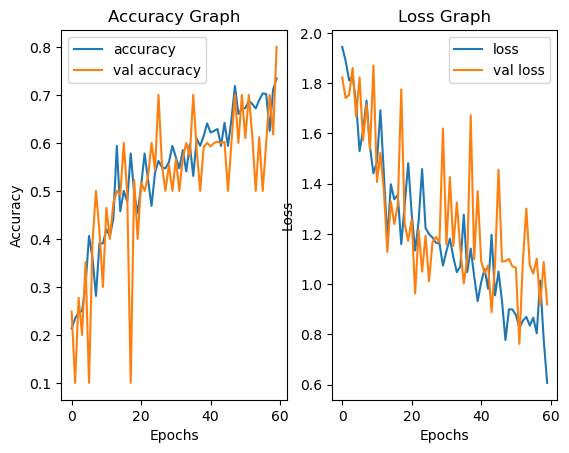

In [11]:
import matplotlib.pyplot as plt

# Accuracy graph
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='accuracy')
plt.plot(val_accuracy, label='val accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# loss graph
plt.subplot(1, 2, 2)
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val loss')
plt.title('Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [12]:
model_json = emotion_model.to_json()
with open("emotion_model4_v23.json", "w") as json_file:
	json_file.write(model_json)
 
# save trained model weight in .h5 file
emotion_model.save_weights('emotion_model4_v23.weights.h5')

In [13]:
emotion_model.save('emotion_model4_v23.h5')

In [14]:
score = emotion_model.evaluate(validation_generator, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.088192343711853
Test accuracy: 0.6167455911636353


In [15]:
print('Final Validation Loss:', val_loss[-1])
print('Final Validation Accuracy:', val_accuracy[-1])

Final Validation Loss: 0.9199695587158203
Final Validation Accuracy: 0.800000011920929
